# **Can Words Reveal Mental Health? A Machine Learning Approach**

## **Aim of the Project**

The aim of this project is to explore whether machine learning models can accurately predict an individual's mental health status based on the content of their written statements.

By analyzing text data utilizing Natural Language Processing (NLP) and range of machine learning (ML) techniques, I aim to detect mental health conditions such as depression, anxiety, or bi-polar disorder and others, given a text input. The central research question guiding this project is:

**Can text-based features from individual's written statements be used to accurately predict their mental health status using machine learning techniques?**

## **Scope of the project**

The project follows a structured pipeline with the following key phases.

1. **Data Preprocessing**: This step involves cleaning the text, handling missing values and duplicates, applying tokenization and lemmatization, and transforming the text into numerical representations using TF-IDF vectorization.

2. **Exploratory Data Analysis** (EDA): EDA is used to gain insights into the distribution of mental health categories, word frequencies across mental health categories, as well as relationships between features and mental health statuses.

3. **Model Building and Evaluation**: Multiple classification algorithms are trained and evaluated, including:
- Logistic Regression
- Multinomial Naive Bayes
- Support Vector Machine (SVM)
- XGBoost
- A feedforward neural network

Model performance will be assessed using accuracy, F1 scores, and confusion matrices to understand how well each model captures the nuances of mental health categories.


## **Dataset**

The dataset is sourced from Kaggle:
https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data

The dataset is a compilation of statements from various publicly availale health datasets and includes labels of one of seven mental health statuses:
- Normal
- Depression
- Suicidal
- Anxiety
- Stress
- Bi-Polar
- Personality Disorder

In total there are 3 columns (`unique_id`, `statement`, `status`) and 53043 rows.

In [1]:
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn import preprocessing
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 1. **Data Preprocessing**

In this section, the data is cleaned and preprocessed for the modelling.

## 1.1 Load and Inspect the Dataset

In [2]:
data = pd.read_csv("combined_data.csv", index_col = 0, header = 0)

data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
data.shape

(53043, 2)

## 1.2. Handle Missing Values and Duplicates

In [4]:
data.isnull().sum()

,0
statement,362
status,0


Since barely 0.6% of data is missing, it was decided to drop rows with missing values.

In [5]:
data = data.dropna(axis = 0, how = "any")

In [6]:
# convert all text and labeles to lowercase
data["statement"] = data["statement"].str.lower()
data["status"] = data["status"].str.lower()
data.head()

,statement,status
0,oh my gosh,anxiety
1,"trouble sleeping, confused mind, restless hear...",anxiety
2,"all wrong, back off dear, forward doubt. stay ...",anxiety
3,i've shifted my focus to something else but i'...,anxiety
4,"i'm restless and restless, it's been a month n...",anxiety


In [7]:
# find duplicate entries based on both statement and label
duplicates = data[data.duplicated(subset = ("statement", "status"), keep = False)]
print("Examples of duplicated rows (same statement & label): ")
print(duplicates.head(10))

Examples of duplicated rows (same statement & label): 
                                             statement   status
18   "no regrets or grudges/angry at things that ha...  anxiety
39   but my heart is still restless even though my ...  anxiety
56                                    why am i nervous  anxiety
88                                             anxious  anxiety
97   "no regrets or grudges/angry at things that ha...  anxiety
132  i want to exhale the restlessness in my chest ...  anxiety
138  but my heart is still restless even though my ...  anxiety
155                              restless and agitated  anxiety
167  i want to exhale the restlessness in my chest ...  anxiety
168                  restless restlessness accompanies  anxiety


In [8]:
# remove duplicates, keeping the first occurence
data = data.drop_duplicates(subset=["statement", "status"], keep="first")
data.shape

(51071, 2)

## 1.3 Text Cleaning

In [9]:
def clean_text(text):
    """
    This function clean text by removing URLs, handles, punctuation, numbers
    and extra whitespaces.
    """
    # remove URL links and markdown-style links
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # remove handles starting with @ (e.g., usernames)
    text = re.sub(r'@\w+', '', text)

    # replace newline with space
    text = text.replace("\n", " ")

    # remove words containing numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)

    # remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove extra whitespaces
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    return text

In [10]:
# apply text cleaning
data['statement'] = data['statement'].apply(clean_text)

# remove empty strings
data = data[data['statement'].str.strip() != ""]

In [11]:
data.head()

,statement,status
0,oh my gosh,anxiety
1,trouble sleeping confused mind restless heart ...,anxiety
2,all wrong back off dear forward doubt stay in ...,anxiety
3,ive shifted my focus to something else but im ...,anxiety
4,im restless and restless its been a month now ...,anxiety


## 1.4 Tokenization

Tokenization is a process of breaking text into words (tokens).

In [12]:
data["tokens"] = data["statement"].apply(word_tokenize)
data.head()

,statement,status,tokens
0,oh my gosh,anxiety,"[oh, my, gosh]"
1,trouble sleeping confused mind restless heart ...,anxiety,"[trouble, sleeping, confused, mind, restless, ..."
2,all wrong back off dear forward doubt stay in ...,anxiety,"[all, wrong, back, off, dear, forward, doubt, ..."
3,ive shifted my focus to something else but im ...,anxiety,"[ive, shifted, my, focus, to, something, else,..."
4,im restless and restless its been a month now ...,anxiety,"[im, restless, and, restless, its, been, a, mo..."


## 1.5 Lemmatization

Lemmatization reduces words to their dictionary base form (lemma) using vocabulary and morphological analysis. It was chosen because it always produces valid dictionary words, unlike stemming.

In [13]:
lemmatizer = WordNetLemmatizer()

def get_pos_tag(pos_tag):
  """
  This function maps POS tags to WordNet tags.
  """
  if pos_tag.startswith('J'):
    return wordnet.ADJ
  elif pos_tag.startswith('V'):
    return wordnet.VERB
  elif pos_tag.startswith('N'):
    return wordnet.NOUN
  elif pos_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN


def lemmatize(tokens):
  """
  This function lemmatizes a list of tokens using POS tagging.
  """
  pos_tags = pos_tag(tokens)
  lemmatized  = [lemmatizer.lemmatize(token, get_pos_tag(pos)) for token, pos in pos_tags]
  return " ".join(lemmatized)

# apply lemmatization
data["lemmatized"] = data["tokens"].apply(lemmatize)
data.head()

,statement,status,tokens,lemmatized
0,oh my gosh,anxiety,"[oh, my, gosh]",oh my gosh
1,trouble sleeping confused mind restless heart ...,anxiety,"[trouble, sleeping, confused, mind, restless, ...",trouble sleep confuse mind restless heart all ...
2,all wrong back off dear forward doubt stay in ...,anxiety,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,ive shifted my focus to something else but im ...,anxiety,"[ive, shifted, my, focus, to, something, else,...",ive shift my focus to something else but im st...
4,im restless and restless its been a month now ...,anxiety,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it be a month now boy...


## 1.6 Feature Engineering

Two numerical features are created:
- `number_of_characters`: The total number of characters in each statement.
- `text_length`: The number of words in each statement.

In [14]:
data["number_of_characters"] = data["statement"].str.len()
data["text_length"] = data["statement"].apply(lambda x: len(x.split()))
data.head()

,statement,status,tokens,lemmatized,number_of_characters,text_length
0,oh my gosh,anxiety,"[oh, my, gosh]",oh my gosh,10,3
1,trouble sleeping confused mind restless heart ...,anxiety,"[trouble, sleeping, confused, mind, restless, ...",trouble sleep confuse mind restless heart all ...,61,10
2,all wrong back off dear forward doubt stay in ...,anxiety,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...,75,14
3,ive shifted my focus to something else but im ...,anxiety,"[ive, shifted, my, focus, to, something, else,...",ive shift my focus to something else but im st...,59,11
4,im restless and restless its been a month now ...,anxiety,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it be a month now boy...,66,14


# 2. **Exploratory Data Analysis (EDA)**

To understand the structure and characteristics of the dataset, the EDA is performed.

## 2.1 Class distribution

In [15]:
counts = data["status"].value_counts()
status = list(data["status"].unique())

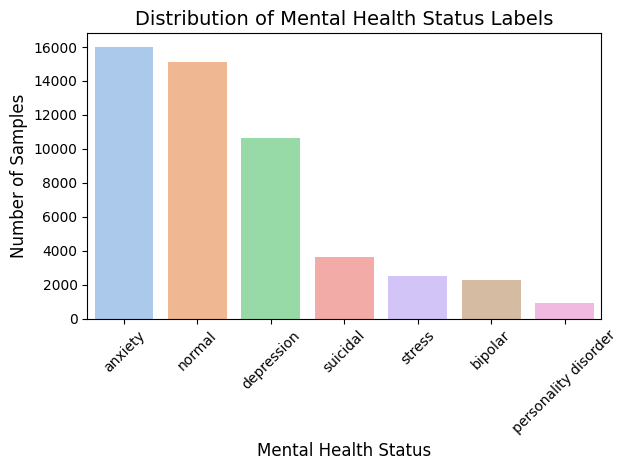

In [16]:
sns.barplot(x = status, y = counts, hue = status, legend = False, palette = 'pastel')

plt.title("Distribution of Mental Health Status Labels", fontsize=14)
plt.xlabel("Mental Health Status", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The dataset is imbalanced, with he most represented class being `anxiety`, followed closely by `normal` and `depression` classes. Less frequent categories include `suicidal`, `stress`, `bipolar` and `personality disorder`. This imabalnce could impact the model performance, and thus resampling might be required.

## 2.2 Text Length by Class

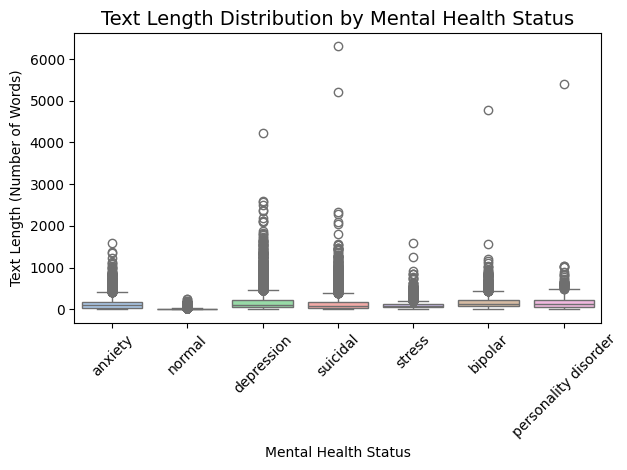

In [17]:
sns.boxplot(data = data, x='status', y='text_length', hue = 'status', legend = False, palette = "pastel")

plt.title("Text Length Distribution by Mental Health Status", fontsize=14)
plt.xlabel("Mental Health Status")
plt.ylabel("Text Length (Number of Words)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The boxplot above visualize the distirbution of word counts (text_length) for each mental health status. Most texts are relatively short, but there are many extreme outliers, especially in the `depression` and `suicidal` categories, where some entries exceed even 4000 or 6000 words.
The `normal` class has much shorter and more consistent texts with fewer outliers, suggesting these are often brief statements.
The high variability and longer texts in some classes may reflect the nature of those mental health conditions, for example, individuals experiencing depressive or suicidal ideation might express themselves in longer, more detailed posts.

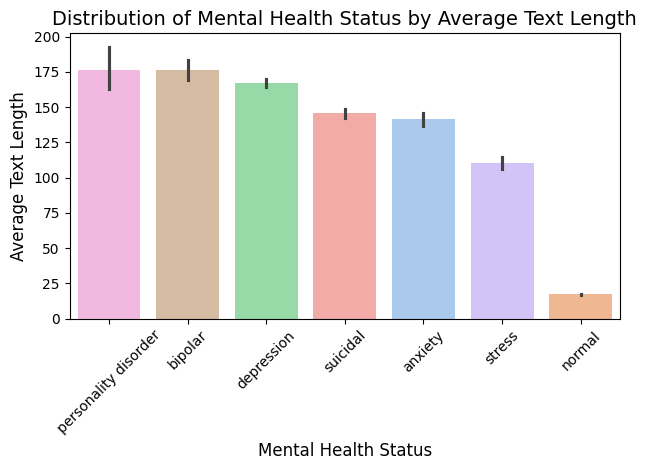

In [18]:
ordered = data.groupby('status')['text_length'].mean().sort_values(ascending=False).index
sns.barplot( data = data, x = "status", y = "text_length", hue = "status", order = ordered, legend = False, palette = 'pastel')

plt.title("Distribution of Mental Health Status by Average Text Length", fontsize=14)
plt.xlabel("Mental Health Status", fontsize=12)
plt.ylabel("Average Text Length", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On average, `personality disorder` and `bipolar` classes have the longest texts, followed by `depression` and `suicidal`.
`Normal` statemens are, on average, significantly shorter than those in other categories, indicating a clear difference in expression length between individuals discussing mental health struggles and those who are not.
The descending trend from `personality disorder` down to `normal` suggests that text length may carry some predictive power when classifying mental health conditions.


## 2.3 Number of Characters by Class

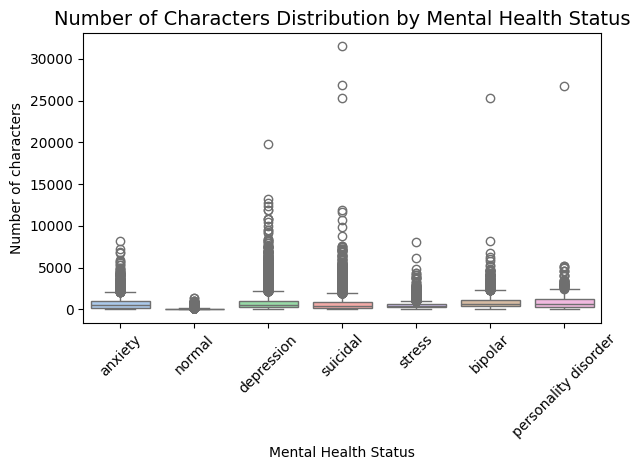

In [85]:
sns.boxplot(data = data, x='status', y='number_of_characters', hue = 'status', legend = False, palette = "pastel")

plt.title("Number of Characters Distribution by Mental Health Status", fontsize=14)
plt.xlabel("Mental Health Status")
plt.ylabel("Number of characters")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

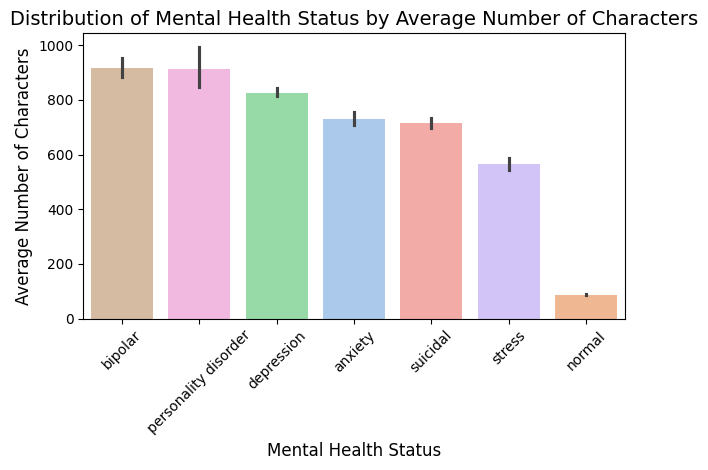

In [86]:
ordered = data.groupby('status')['number_of_characters'].mean().sort_values(ascending=False).index
sns.barplot( data = data, x = "status", y = "number_of_characters", hue = "status", order = ordered, legend = False, palette = 'pastel')

plt.title("Distribution of Mental Health Status by Average Number of Characters", fontsize=14)
plt.xlabel("Mental Health Status", fontsize=12)
plt.ylabel("Average Number of Characters", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Similarly, on average, `personality disorder` and `bipolar` classes have the longest texts in terms of characters, followed by `depression`.
`Normal` statemens are, on average, significantly shorter in characters than those in other categories, again indicating a difference between individuals discussing mental health struggles and those who are not.

Therefore, numerical features such as `text_length` and `number_of_characters` might have some predicitve power and thus contribute to the prediction of mental health status.

## 2.4 Word Frequency Analysis

Most frequent words in for each inidivudal mental health condition are analyzed. Next, WordClouds are created to visualize the most prominient terms.

In [19]:
def top_words_frequency(data, label_column, text_column, label_value, n_words = 20):
    data = data[data[label_column] == label_value]
    vectorizer = CountVectorizer(stop_words = "english")
    X = vectorizer.fit_transform(data[text_column])
    sum_words = X.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_words = words_freq[:n_words]

    return top_words, dict(words_freq)

In [20]:
def wordcloud(words_frequencies, title = None, colormap = "gnuplot"):
    wordcloud = WordCloud(background_color = "white", colormap = colormap)
    wordcloud.generate_from_frequencies(words_frequencies)
    plt.figure()
    if title:
        plt.title(title)

    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

### 2.4.1 **Normal Class**

In [21]:
normal_top, normal_frequencies = top_words_frequency(data, 'status', 'lemmatized', 'normal')

for word, freq in normal_top:
    print(f"{word}: {freq}")

want: 1374
im: 1344
like: 1294
just: 1275
dont: 928
time: 910
know: 859
really: 854
make: 793
work: 793
good: 771
think: 763
day: 740
people: 637
say: 617
feel: 611
come: 597
year: 533
look: 529
love: 516


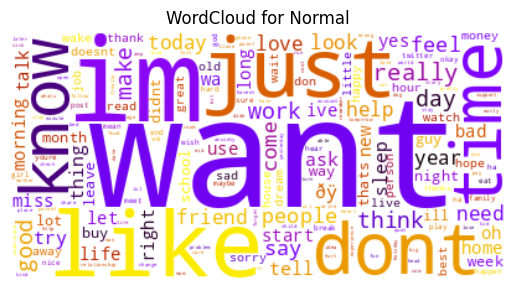

In [87]:
wordcloud(normal_frequencies, title = 'WordCloud for Normal')

The most frequent words used in `normal` class seem to have rather a neutral meaning.

### 2.4.2 **Depression**

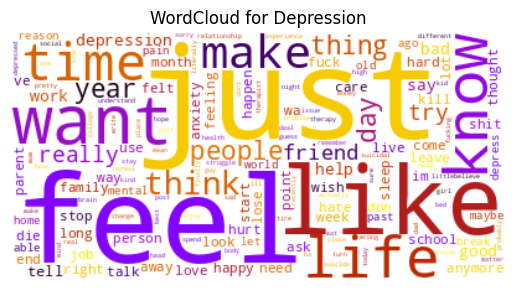

In [23]:
depression_top, depression_frequencies = top_words_frequency(data, 'status', 'lemmatized', 'depression')
wordcloud(depression_frequencies, title = 'WordCloud for Depression')

### 2.4.3 **Anxiety**

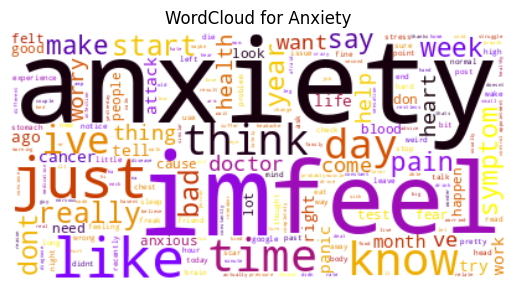

In [24]:
anxiety_top, anxiety_frequencies = top_words_frequency(data, 'status', 'lemmatized', 'anxiety')
wordcloud(anxiety_frequencies, title = 'WordCloud for Anxiety')

### 2.4.4 **Suicidial**

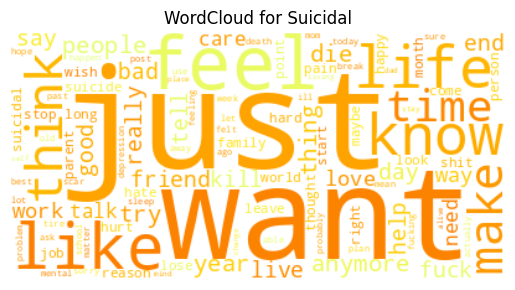

In [25]:
suicidal_top, suicidal_frequencies = top_words_frequency(data, 'status', 'lemmatized', 'suicidal')
wordcloud(suicidal_frequencies, title = 'WordCloud for Suicidal', colormap = "Wistia_r")

### 2.4.5 **Stress**

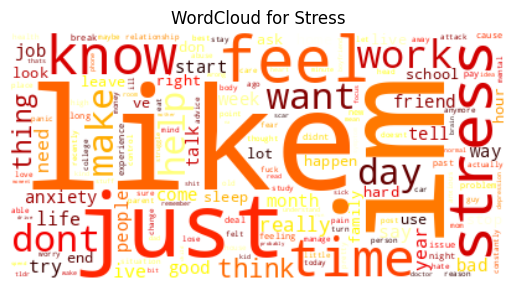

In [26]:
stress_top, stress_frequencies = top_words_frequency(data, 'status', 'lemmatized', 'stress')
wordcloud(stress_frequencies, title = 'WordCloud for Stress', colormap = "hot")

### 2.4.6 **Bi-Polar**

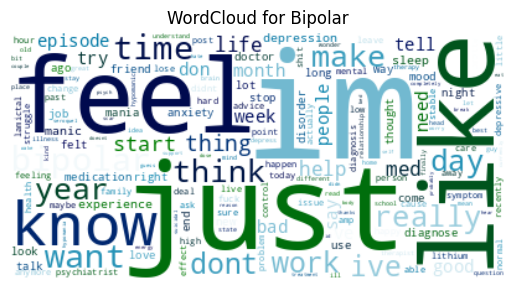

In [27]:
bipolar_top, bipolar_frequencies = top_words_frequency(data, 'status', 'lemmatized', 'bipolar')
wordcloud(bipolar_frequencies, title = 'WordCloud for Bipolar', colormap = "ocean")

### 2.4.7 **Personality Disorder**

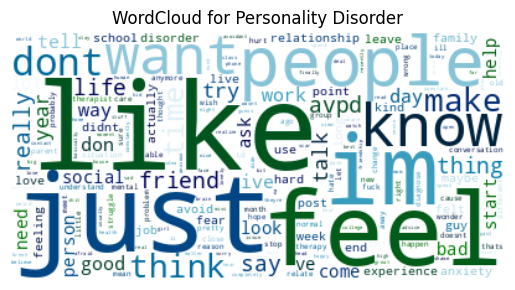

In [28]:
personality_top, personality_frequencies = top_words_frequency(data, 'status', 'lemmatized', 'personality disorder')
wordcloud(personality_frequencies, title = 'WordCloud for Personality Disorder', colormap = "ocean")

In each of the category some words seem to be almost always present, e.g., 'feel', 'like', 'im', 'just', 'know', 'time'. This may reflect rather common emotional expression and introspective tone, regardless of diagnosis. In `anxiety` Wordcloud, words that refer to physical and emotional symptoms such as: 'heart', 'attack', 'panic', 'headache', 'worry' are present. WordClouds in `depression` and `suicidal` seem to have some overlap e.g., 'fuck', 'die'. Moreover, a lot of vulgarisms are visible in these two classes. In other classes, words that are specific to the disorder are common. For example, in `bipolar` words such as 'bipolar', 'manic', 'depression', 'episode', 'mania' occur often. In `personality disorder` words such as 'avpd', 'therapy' occur.

# 3. **Baseline Models**

In this section, several baseline models are build and evaluated using TF-IDF features extracted from the lemmatized statements, along with optional numerical features like text length. The performance is compared using accuracy, F1 scores and confusion matrices.

## 3.1 Data Preparation for Modeling

In [29]:
# select features for modelling: lemmatized text and numerical features such as text length and number of characters
x = data[['lemmatized', 'number_of_characters', 'text_length']]
y = data['status']

# encode class labels into numeric format
le = preprocessing.LabelEncoder()

y = le.fit_transform(y.values)

In [30]:
le.classes_

array(['anxiety', 'bipolar', 'depression', 'normal',
       'personality disorder', 'stress', 'suicidal'], dtype=object)

In [31]:
# split data into training and testing set (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## 3.2 TF-IDF Vectorization


Term-Frequency Inverse Document Frequency (TF-IDF) is applied. TF-IDF is a measure used to evaluate how important a word is to a document in a collection of documents. Unlike raw counts, TF-IDF reduces the weight of common words while boosting rare and potentially meaningful words. It is used because it not only balances frequency and uniqueness but also it propduces normalzied features vectors which work well with linear models.

`ngram_range` is set to (1, 2) in order to include both single words and common bigrams (e.g., “feel sad”, “want help”), which may capture richer patterns in how people express different mental states.

`stop_words` = 'english' tells the vectorizer to ignore common English stop words such as 'the', 'is', 'and' etc. These words tend to carry little discriminative value and may add noise, thus they were removed.

`max_features` = 30000, means that only 30,000 most informative n-grams are kept. It serves as a dimensionality reduction.

In [32]:
# apply TF-IDF vectorization on the lemmatized text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words = "english", max_features = 30000)

x_train_vectors = vectorizer.fit_transform(x_train["lemmatized"])
x_test_vectors = vectorizer.transform(x_test["lemmatized"])

In [33]:
x_train_combined = hstack([x_train_vectors, x_train[['number_of_characters', 'text_length']].values])
x_test_combined = hstack([x_test_vectors, x_test[['number_of_characters', 'text_length']].values])

In [34]:
x_train_combined.shape

(35737, 30002)

## 3.3 Re-sampling

Due to the distribution of mental health categories being imbalanced, the resampling technique is applied. This is done in order to prevent machine learning models becoming biased toward majority classes, leading to poor performance on underrepresented categories.

In [35]:
# apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train_combined, y_train)

In [36]:
x_train_resampled.shape

(77777, 30002)

In [37]:
print("After Oversampling:")
resampled_counts = Counter(y_train_resampled)
for label, count in sorted(resampled_counts.items()):
    print(f"Class {label}: {count}")

After Oversampling:
Class 0: 11111
Class 1: 11111
Class 2: 11111
Class 3: 11111
Class 4: 11111
Class 5: 11111
Class 6: 11111


## 3.4 Logistic Regression

In [38]:
# train logistic regression model
log_reg = LogisticRegression(random_state=42, solver="liblinear", max_iter=1000)
log_reg.fit(x_train_resampled, y_train_resampled)

# predict and evaluate
pred_labels = log_reg.predict(x_test_combined)


print("Classification Report - Logistic Regression:")
print(classification_report(y_test, pred_labels))

print("F1 Micro: ", f1_score(y_test, pred_labels, average="micro"))
print("F1 Macro: ", f1_score(y_test, pred_labels, average="macro"))

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1054
           1       0.73      0.77      0.75       799
           2       0.78      0.58      0.67      4485
           3       0.87      0.90      0.89      4895
           4       0.43      0.67      0.52       272
           5       0.45      0.68      0.54       672
           6       0.65      0.70      0.67      3139

    accuracy                           0.74     15316
   macro avg       0.66      0.73      0.69     15316
weighted avg       0.75      0.74      0.74     15316

F1 Micro:  0.7418386001566989
F1 Macro:  0.6877335385117522


In [39]:
labels = le.classes_

def plot_cm(y_true, y_pred, labels, title):
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(title)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

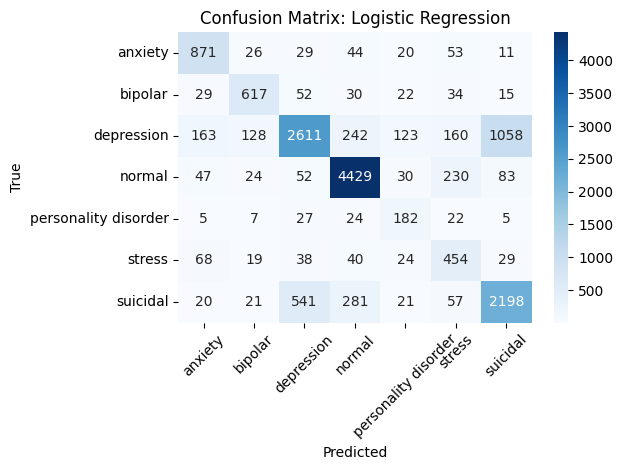

In [40]:
plot_cm(y_test, pred_labels, labels, "Confusion Matrix: Logistic Regression")

In [41]:
def plot_f1_perclass(y_true, y_pred, label_encoder, title = "Per-Class F1 Scores"):
  """
  This function plots per-class F1 scores for classification results.

  Parameters:
  - y_true: true labels
  - y_pred: predicted labels
  - label_encoder: fitted sklearn LabelEncoder used to decode labels
  - title: title of the plot
  """
  # get classification report as dict
  report_dict = classification_report(y_test, y_pred, output_dict=True)

  # extract per-class F1 scores
  class_names = le.classes_
  f1_scores = [report_dict[str(i)]["f1-score"] for i in range(len(class_names))]

  sns.barplot(x = class_names, y = f1_scores, hue = class_names, legend = False, palette = 'pastel')

  plt.title("Model Comparison", fontsize=14)
  plt.xlabel("Model", fontsize=12)
  plt.ylabel("F1 Scores", fontsize=12)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

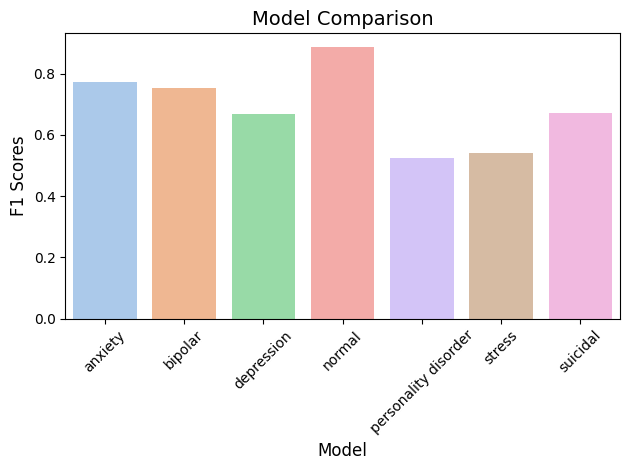

In [42]:
plot_f1_perclass(y_test, pred_labels, le)

The overall accuracy of the model is 0.74.The logistic regression model performs well on `normal` and `anxiety` classes, with high recall (90% and 83% respectively). However, it struggles to distinguish between `depression`, `stress`, and `suicidal` categories, especially confusing depression with suicidal over 1,000 times. Classes like personality disorder and stress show lower precision and F1 scores, likely due to overlapping language with other mental states. The F1 score is the highest for `normal` class, meaning that the classification is performed most accurately for this class.

## 3.5 Naive Bayes

In [43]:
# traing naive bayes model
nb_model = MultinomialNB()
nb_model.fit(x_train_resampled, y_train_resampled)

MultinomialNB()

In [44]:
# test and evaluate
nb_predictions = nb_model.predict(x_test_combined)
print("Classification Report - Naive Bayes:")
print(classification_report(y_test, nb_predictions))

print("F1 Micro:", f1_score(y_test, nb_predictions, average="micro"))
print("F1 Macro:", f1_score(y_test, nb_predictions, average="macro"))

Classification Report - Naive Bayes:
              precision    recall  f1-score   support

           0       0.60      0.80      0.69      1054
           1       0.45      0.80      0.57       799
           2       0.68      0.57      0.62      4485
           3       0.94      0.62      0.75      4895
           4       0.22      0.78      0.34       272
           5       0.28      0.51      0.36       672
           6       0.62      0.67      0.64      3139

    accuracy                           0.63     15316
   macro avg       0.54      0.68      0.57     15316
weighted avg       0.71      0.63      0.65     15316

F1 Micro: 0.6339775398276313
F1 Macro: 0.5678913942086063


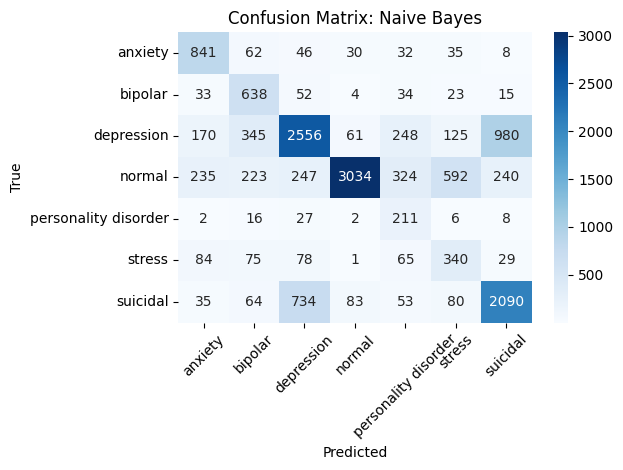

In [45]:
# confusion matrix
plot_cm(y_test, nb_predictions, labels, "Confusion Matrix: Naive Bayes")

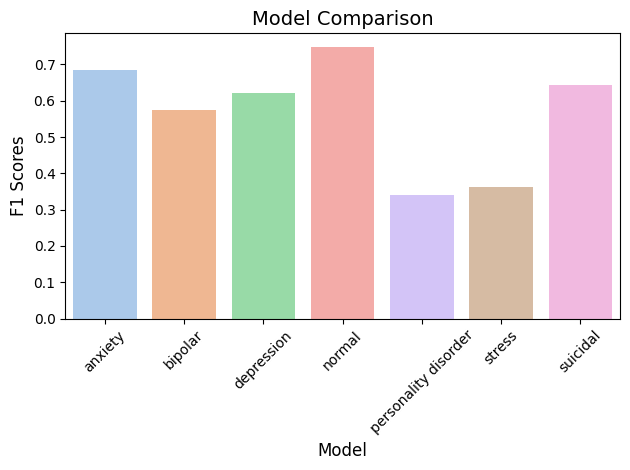

In [46]:
plot_f1_perclass(y_test, nb_predictions, le)

The Naive Bayes model achieves an overall accuracy of 0.63, which is notably lower than Logistic Regression. Based on the confusion matrix, it can be seen that the model missclassifies a lot.

## 3.6 SVM (Linear Support Vector Machine)

In [47]:
from sklearn.svm import LinearSVC

In [48]:
# traing SVM model
svm_model = LinearSVC(class_weight = "balanced", random_state = 42, max_iter = 10000)

In [49]:
svm_model.fit(x_train_resampled, y_train_resampled)

LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)

In [50]:
# test and evaluate
svm_predictions = svm_model.predict(x_test_combined)

In [51]:
print("Classification Report - SVM:")
print(classification_report(y_test, svm_predictions))

print("F1 Micro:", f1_score(y_test, svm_predictions, average="micro"))
print("F1 Macro:", f1_score(y_test, svm_predictions, average="macro"))

Classification Report - SVM:
              precision    recall  f1-score   support

           0       0.71      0.82      0.77      1054
           1       0.73      0.78      0.75       799
           2       0.78      0.57      0.66      4485
           3       0.86      0.88      0.87      4895
           4       0.45      0.67      0.54       272
           5       0.43      0.67      0.52       672
           6       0.65      0.71      0.68      3139

    accuracy                           0.73     15316
   macro avg       0.66      0.73      0.68     15316
weighted avg       0.75      0.73      0.74     15316

F1 Micro: 0.7347871506920867
F1 Macro: 0.6837731459169699


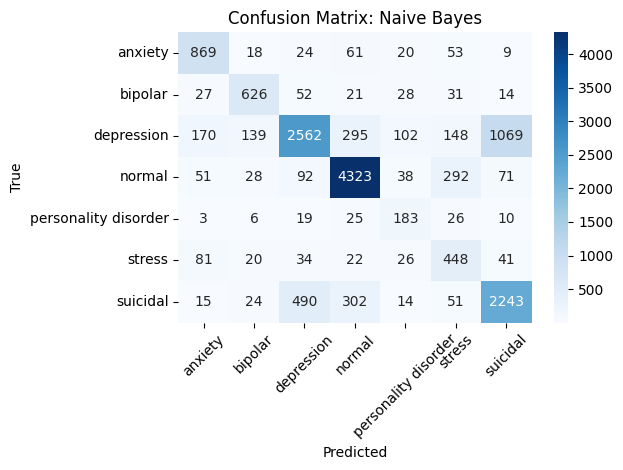

In [52]:
# confusion matrix
plot_cm(y_test, svm_predictions, labels, "Confusion Matrix: Naive Bayes")

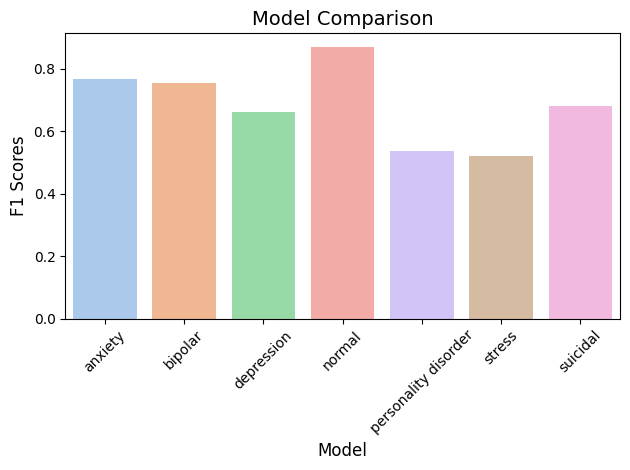

In [53]:
plot_f1_perclass(y_test, svm_predictions, le)

The SVM model performs competitively with Logistic Regression, achieving overall accuracy of 0.73. Most of the F1 scores in SVM are either equal or greater than in Logistic Regression.


## 3.7 XGBoost

In [54]:
# train XGB classifier
# three_method of gpu_hist was used due to long training time
xgb_classifier = XGBClassifier(learning_rate = 0.2, max_depth = 8, n_estimators = 200, random_state = 42, tree_method='gpu_hist')

In [55]:
xgb_classifier.fit(x_train_resampled, y_train_resampled)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [56]:
# test and evaluate
xgb_predictions = xgb_classifier.predict(x_test_combined)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [57]:
print("Classification Report - XGB Classifier:")
print(classification_report(y_test, xgb_predictions))

print("F1 Micro:", f1_score(y_test, xgb_predictions, average="micro"))
print("F1 Macro:", f1_score(y_test, xgb_predictions, average="macro"))

Classification Report - XGB Classifier:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1054
           1       0.82      0.77      0.79       799
           2       0.75      0.65      0.70      4485
           3       0.90      0.90      0.90      4895
           4       0.67      0.56      0.61       272
           5       0.47      0.65      0.54       672
           6       0.65      0.72      0.68      3139

    accuracy                           0.76     15316
   macro avg       0.72      0.72      0.72     15316
weighted avg       0.77      0.76      0.76     15316

F1 Micro: 0.7620135805693392
F1 Macro: 0.7161513331161077


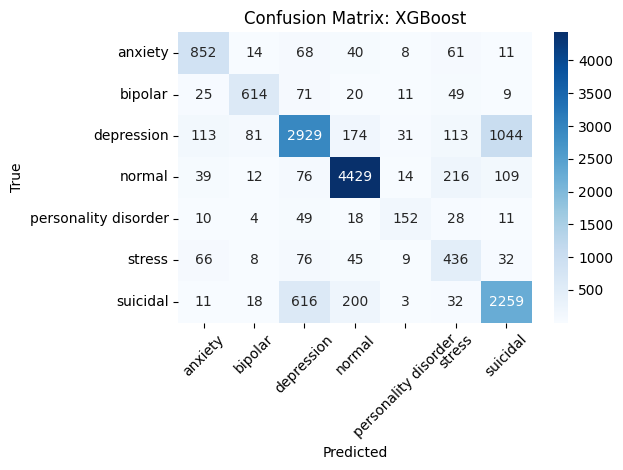

In [58]:
plot_cm(y_test, xgb_predictions, labels, "Confusion Matrix: XGBoost")

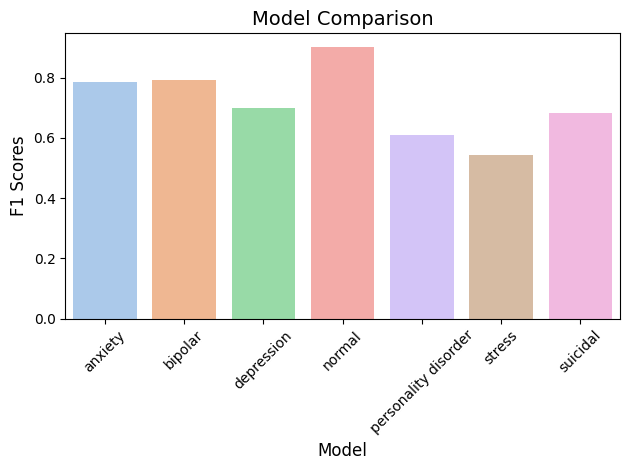

In [59]:
plot_f1_perclass(y_test, xgb_predictions, le)

The XGBoost model achieves so far the best accuracy of 0.76. Moreover, the F1 scores of particular classes are also the highest out of all ML algorithms.

## 3.5 Model Comparison

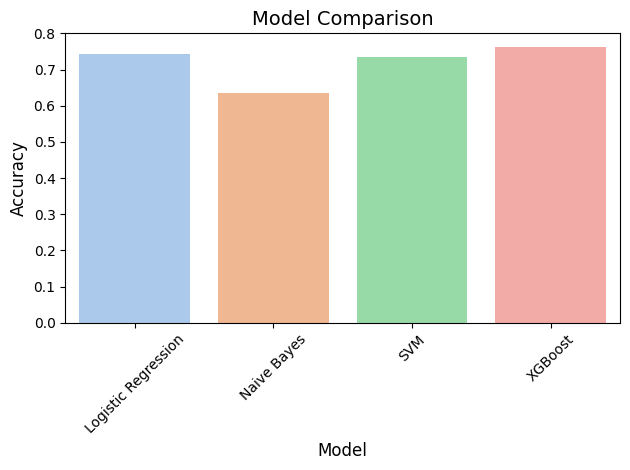

In [60]:
accuracy_scores = [accuracy_score(y_test, pred_labels), accuracy_score(y_test, nb_predictions),
                   accuracy_score(y_test, svm_predictions), accuracy_score(y_test, xgb_predictions)]

models = ["Logistic Regression", "Naive Bayes", "SVM", "XGBoost"]


sns.barplot(x = models, y = accuracy_scores, hue = models, legend = False, palette = 'pastel')

plt.title("Model Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Among all models, XGBoost achieved the highest accuracy of 0.76, closely followed by Logistic Regression and SVM. The Naive Bayes classifier performed the worst.

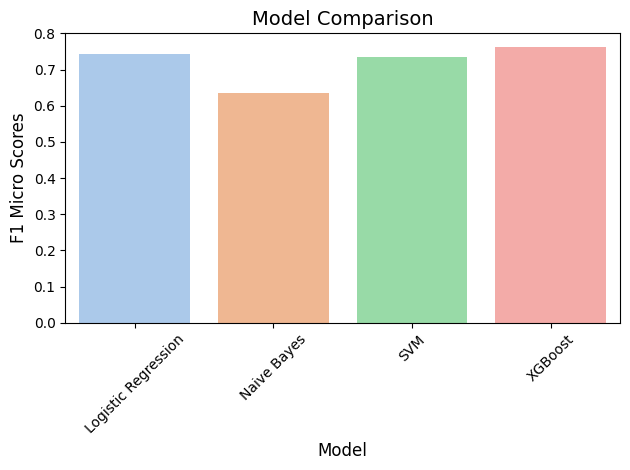

In [61]:
f1_scores_micro = [f1_score(y_test, pred_labels, average="micro"), f1_score(y_test, nb_predictions, average="micro"),
                   f1_score(y_test, svm_predictions, average="micro"), f1_score(y_test, xgb_predictions, average="micro")]

models = ["Logistic Regression", "Naive Bayes", "SVM", "XGBoost"]

sns.barplot(x = models, y = f1_scores_micro, hue = models, legend = False, palette = 'pastel')

plt.title("Model Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Micro Scores", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

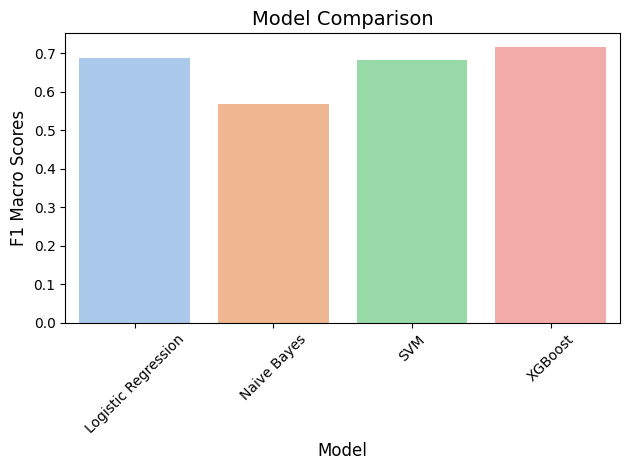

In [62]:
f1_scores_macro = [f1_score(y_test, pred_labels, average="macro"), f1_score(y_test, nb_predictions, average="macro"),
                   f1_score(y_test, svm_predictions, average="macro"), f1_score(y_test, xgb_predictions, average="macro")]

models = ["Logistic Regression", "Naive Bayes", "SVM", "XGBoost"]

sns.barplot(x = models, y = f1_scores_macro, hue = models, legend = False, palette = 'pastel')

plt.title("Model Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Macro Scores", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Among all models tested, XGBoost achieved the highest performance in F1 scores, followed by SVM and Logistic Regression. Naive Bayes performed the weakest overall.

In general, F1 macro scores tend to be lower as they calculate the F1 score for each class separately and then taking average, treating all classess equally. This accounts for the possible class imabalances. F1 micro scores, in contrast, average the performance by considering all individual predictions (favoring classes with more samples).



## 4. **Deep Learning Approach (PyTorch)**

After evaluating several classical machine learning algorithms, I wanted to explore whether a neural network could outperform these models by capturing more complex, non-linear relationships in the data. While traditional models tend to work well with TF-IDF features due to their simplicity and sparsity, neural networks have the theoretical advantage of learning more abstract feature representations when given enough data and depth. Therefore, in this section, I implement and evaluate several feedforward neural networks using PyTorch, starting with a simple architecture and gradually increasing its complexity. The model is trained to predict mental health status simply based on TF-IDF vectorized text data.


In [63]:
# define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4.1 Data Preparation

In [64]:
# only the text data was used as input due to problems with running the model
x = data["statement"]
y = data['status']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# TF-IDF vectorization
# max_features were reduced to 5000, otherwise the program crashes
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words = "english", max_features = 5000)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)


# handle class imbalances with oversampling
ros = RandomOverSampler(random_state=101)
train_vectors, y_train = ros.fit_resample(train_vectors, y_train)

# encode class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

In [65]:
# convert matrices to tensors
train_arr = train_vectors.toarray()
test_arr = test_vectors.toarray()

x_train_tensor = torch.tensor(train_arr, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype = torch.long)

x_test_tensor = torch.tensor(test_arr, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype = torch.long)

# create PyTorch datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64)

In [66]:
# number of features
input_dim = x_train_tensor.shape[1]

In [67]:
class ShallowNNClassifier(nn.Module):
    """
    A simple feedforward neural network with one hidden layer.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
      super(ShallowNNClassifier, self).__init__()
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(0.3)
      self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      x = self.dropout(self.relu(self.fc1(x)))
      return self.fc2(x)

In [68]:
# initalize model, loss function, and optimizer
model_shallow = ShallowNNClassifier(input_dim = input_dim, hidden_dim = 128, output_dim = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_shallow.parameters(), lr = 0.01)

In [69]:
# training function

def train_NN(model, train_loader, criterion, optimizer, device, num_epochs = 10):
  model.train()
  for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      optimizer.zero_grad()
      outputs = model(batch_x)
      loss = criterion(outputs, batch_y)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss: .4f}")

In [70]:
# evaluation function

def evaluate_NN(model, test_loader, label_encoder, y_test):
  model.eval()
  all_predictions = []
  with torch.no_grad():
    for batch_x, _ in test_loader:
      batch_x = batch_x.to(device)
      outputs = model(batch_x)
      predictions = torch.argmax(outputs, dim = 1)
      all_predictions.extend(predictions.cpu().numpy())

    y_predictions_labels = label_encoder.inverse_transform(all_predictions)

    print(classification_report(y_test, y_predictions_labels))
    print("F1 Micro:", f1_score(y_test, y_predictions_labels, average="micro"))
    print("F1 Macro:", f1_score(y_test, y_predictions_labels, average="macro"))


In [71]:
train_NN(model_shallow, train_loader, criterion, optimizer, device)

Epoch 1/10, Loss:  553.9651
Epoch 2/10, Loss:  231.3295
Epoch 3/10, Loss:  145.7370
Epoch 4/10, Loss:  98.2057
Epoch 5/10, Loss:  75.0712
Epoch 6/10, Loss:  63.6881
Epoch 7/10, Loss:  55.4793
Epoch 8/10, Loss:  49.1038
Epoch 9/10, Loss:  48.5620
Epoch 10/10, Loss:  43.2890


In [72]:
evaluate_NN(model_shallow, test_loader, label_encoder, y_test)

                      precision    recall  f1-score   support

             anxiety       0.77      0.74      0.76      1054
             bipolar       0.85      0.67      0.75       799
          depression       0.65      0.69      0.67      4485
              normal       0.88      0.89      0.88      4895
personality disorder       0.83      0.45      0.59       272
              stress       0.53      0.43      0.48       672
            suicidal       0.62      0.66      0.64      3139

            accuracy                           0.73     15316
           macro avg       0.73      0.65      0.68     15316
        weighted avg       0.74      0.73      0.73     15316

F1 Micro: 0.7330242883259337
F1 Macro: 0.6800284818662495


While the shallow neural network showed decent performance (similar as ML models), I wanted to investigate whether adding another hidden layer could help the model learn more abstract representations and improve generalization. Therefore, I extended the architecture by stacking an additional fully connected layer.

In [73]:
class DeepNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
      super(DeepNN, self).__init__()
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, hidden_dim)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(0.3)
      self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      x = self.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)

      return x



In [74]:
model_deep = DeepNN(input_dim = input_dim, hidden_dim = 128, output_dim = num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deep.parameters(), lr = 0.01)

In [75]:
train_NN(model_deep, train_loader, criterion, optimizer, device)

Epoch 1/10, Loss:  622.9082
Epoch 2/10, Loss:  312.7366
Epoch 3/10, Loss:  256.6836
Epoch 4/10, Loss:  215.8206
Epoch 5/10, Loss:  179.6127
Epoch 6/10, Loss:  161.1950
Epoch 7/10, Loss:  145.0486
Epoch 8/10, Loss:  134.2233
Epoch 9/10, Loss:  122.2358
Epoch 10/10, Loss:  114.1602


In [76]:
evaluate_NN(model_deep, test_loader, label_encoder, y_test)

                      precision    recall  f1-score   support

             anxiety       0.76      0.75      0.76      1054
             bipolar       0.82      0.69      0.75       799
          depression       0.65      0.72      0.68      4485
              normal       0.85      0.93      0.89      4895
personality disorder       0.75      0.48      0.59       272
              stress       0.59      0.28      0.38       672
            suicidal       0.65      0.57      0.61      3139

            accuracy                           0.73     15316
           macro avg       0.72      0.63      0.66     15316
        weighted avg       0.73      0.73      0.72     15316

F1 Micro: 0.7319143379472447
F1 Macro: 0.6636142102612393


Although the deeper network added more capacity, it did not significantly outperform the shallow model. To further improve training stability and address potential internal covariate shift, I incorporated Batch Normalization layers into the deep architecture. This aims to stabilize learning and potentially boost performance.

In [77]:
class DeepNNBatch(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepNNBatch, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [78]:
model_deepbatch = DeepNNBatch(input_dim = input_dim, hidden_dim = 128, output_dim = num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deepbatch.parameters(), lr = 0.01)

In [79]:
train_NN(model_deepbatch, train_loader, criterion, optimizer, device)

Epoch 1/10, Loss:  651.3308
Epoch 2/10, Loss:  345.5685
Epoch 3/10, Loss:  272.1855
Epoch 4/10, Loss:  225.4766
Epoch 5/10, Loss:  192.2548
Epoch 6/10, Loss:  163.1533
Epoch 7/10, Loss:  145.3405
Epoch 8/10, Loss:  129.1393
Epoch 9/10, Loss:  118.1991
Epoch 10/10, Loss:  108.8291


In [80]:
evaluate_NN(model_deepbatch, test_loader, label_encoder, y_test)

                      precision    recall  f1-score   support

             anxiety       0.76      0.75      0.75      1054
             bipolar       0.78      0.65      0.71       799
          depression       0.68      0.66      0.67      4485
              normal       0.86      0.92      0.89      4895
personality disorder       0.61      0.51      0.56       272
              stress       0.53      0.42      0.47       672
            suicidal       0.62      0.64      0.63      3139

            accuracy                           0.73     15316
           macro avg       0.69      0.65      0.67     15316
        weighted avg       0.73      0.73      0.73     15316

F1 Micro: 0.7340689475058763
F1 Macro: 0.6696136974976205


The Deep Neural Network with Batch Normalization did not improve in accuracy.

The Shallow Neural Network actually performed the best across accuracy, F1 micro, and F1 macro, despite being the simplest. In general, it offers best general performance across classes, lower training time and less risk of overfitting compared to deeper variants. This would suggests this problem, simpler architectures may be more effective and less prone to overfitting.

Still, the baseline models like logsitic regression, SVM and XGBoost perform better than NN model. This might be because of few reasons.

- TF-IDF ignores syntax, grammar and word order which works well for baseline models as they can extract signals based on single words, but in NNs context and semantic meaning could be valuable.

- NNs have much more parameters such as learning rates, weight initalization, early stopping etc., which results in additional optimization needs. In this case, no additional parameter tuning was used and thus it could influence the results.

- In NN models, the numerical data was not used due to running constraints. This could affect the accuracy as well.

# 5. **Conclusion**

This project aimed to investigate whether machine learning models can effectively classify individuals' mental health status based on text statements. Through experimentation with both traditional models (Logistic Regression, Naive Bayes, SVM, XGBoost) and deep learning approaches (Feedforward Neural Networks using PyTorch), it was found that machine learning models can achieve a reasonably high level of accuracy in this task.
Among all models tested, XGBoost emerged as the top performer, delivering the highest accuracy and F1 scores across most classes. Surprisingly, other simple ML models such like Logistic Regression and SVM outperformed deeper neural networks, which suggests that for sparse, high-dimensional data like TF-IDF, traditional algorithms remain highly effective and efficient.
The deep learning models, while promising in theory, struggled to outperform classical approaches, which could be due to the limitations of TF-IDF representations and minimal tuning.


# 6. **Limitations**

- TF-IDF vectorization: While TF-IDF offers a nuanced representation combining term frequency with inverse document frequency, it ignores word order, syntax or context. Thus, important linguistic nuances or emotional tone may be lost, limiting the model's ability to understand and interpret. This could also be a likely explanation for why neural networks did not outperform basic models.

- NN architecture: the implemented neural networks models were rather simple and had limited hyperparameter tuning. The classification could benefit from more advanced architectures such as transformers which could be suited better for modeling the language, potentially improving performance.

- RandomOverSampler: to make the classes balanced, it duplicated minority classes examples synthetically, which could lead to potential overfitting and overoptimistic performance, particularly for rare categories such as personality disorder.


# 7. **Future Work**

The limitations from the section above could be addressed.

Additionally, I consider simplifying the multi-class classification problem into a binary classification problem, which would involve distinguishing between text statements of individuals showing signs of any mental health disorder versus those without it. This idea emerged from observing significant overlap in the language across some categories e.g., depression and suicidal. Moreover, many symptoms for mental health disorders overlap, which also could be reflected in text statements. By aggregating all disorder categories into one class, the model might learn to better capture general patterns of psychological disorders. This could potentially lead to better overall performance and could serve as a useful early-warning tool for identification of individuals who could benefit from further screening or professional support.
